In [243]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import transit
import george
from george import kernels

I first read the data obtained with the Keck telescope into the frame data

In [244]:
newdata = pd.read_table('Keckdata.txt', skiprows=[0, 2], sep='\s+')

And I select the three important variables, with the option to add an error in quadrature

In [245]:
bjd = np.array(newdata['JD-2.44e6'], 'd')
rvs = np.array(newdata['mnvel'], 'd')
rverr = np.array(newdata['errvel'], 'd')
additionalerr = 0.0

Now I use the orbital ephemeris obtained from the transits to define the orbital phases, and I also define a new zero point for the BJD timestamps

In [246]:
period = 0.6892099
tc = 2454953.1910
tc = tc-2440000.0

phasesaux = (bjd-tc)/period
phases, orbit = np.modf(phasesaux)

phases = phases
bjdlv = np.mean(bjd)
bjdrest, bjdint = np.modf(bjdlv)

phi0 = (bjdint-tc)/period
aux, phi0 = phi0-np.modf(phi0)

shortbjd = bjd-bjdint

Now I define a function that calculates the log of the likelihood for the fit

In [247]:
def simplemodel(theta, phases):
    K, gamma, prot, h, sigma  = theta
    return -K*np.sin(2.0*np.pi*phases)

In [248]:
def lnlike(theta, phases, shortbjd, rvs, error):
    "Model to fit a sinusoid to the RV data"
    K, gamma, prot, h, sigma = theta

    theoRV = simplemodel(theta, phases)
    
    gp = george.GP(kernels.WhiteKernel(sigma**2)+kernels.ExpSine2Kernel(gamma, prot)*h**2)
    gp.compute(shortbjd, error)
    return gp.lnlikelihood(rvs - simplemodel(theta, phases))

In [249]:
def lnprior(theta):
    K, gamma, prot, h, sigma= theta
    if  0 <= gamma <= 100 and 0 <= h and 0< sigma:
        return -0.5*((prot-32.0)/1.0)**2
    return -np.inf

In [250]:
def lnprob(theta, phases, shortbjd, rvs, error):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, phases, shortbjd, rvs, error)

And I obtain the best fit parameters, their uncertainties, and I plot the observations and the model

In [251]:
nll = lambda *args: -lnprob(*args)
result = op.minimize(nll, [4.0, 1.0, 30, 5.0, 2.0], 
                     args=(phases, shortbjd, rvs, rverr), tol=0.01, options={'disp': True, 'maxiter':100000}, method='BFGS')
K_ml, gamma_ml, prot_ml, h_ml, sigma_ml = result["x"]
error = np.sqrt(rverr**2+ 0.0*sigma_ml**2)
print result["x"]

Optimization terminated successfully.
         Current function value: 70.020298
         Iterations: 14
         Function evaluations: 126
         Gradient evaluations: 18
[  3.82110694   7.64148629  31.09743738   6.33476792   2.65374675]


With the best fit solution, it is time to run and MCMC routine to estimate the uncertainties on the parameters

In [252]:
ndim, nwalkers = 5, 100
pos = [result["x"]*(1+5e-3*np.random.randn(ndim)) for i in range(nwalkers)]

In [253]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(phases, shortbjd, rvs, rverr))
sampler.run_mcmc(pos, 5000)

(array([[  3.64277717,   3.58414393,  31.11773139,   9.32787803,
           4.38182908],
        [  4.32809687,  10.55950723,  32.2399744 ,   4.41984169,
           3.88811046],
        [  3.71977623,   7.62110751,  31.65656414,   5.75885451,
           2.31614424],
        [  3.15036883,  16.05998919,  32.78088102,   8.37391616,
           3.20877174],
        [  4.6188461 ,  29.11405709,  31.49359065,   9.94675368,   2.8973719 ],
        [  3.64035816,   6.68870072,  31.21685195,   8.64322585,
           2.95812959],
        [  3.65855063,  13.51739856,  30.44445369,   9.47289198,
           1.60385013],
        [  5.4269437 ,   3.26367608,  31.17539579,   6.6666117 ,
           3.68673879],
        [  4.19480069,  20.30661134,  33.05348571,   3.65026052,
           3.34853298],
        [  1.89917753,  29.01874788,  30.87796966,  10.786016  ,
           0.40684554],
        [  1.51942755,  16.46366621,  31.14502883,   8.80008302,
           3.91217491],
        [  2.61181908,  85.042

In [254]:
samples = sampler.chain[:, 500:, :].reshape((-1, ndim)) #Burn in portion to remove (currently %10)

Now I plot the results in a triangle plot 

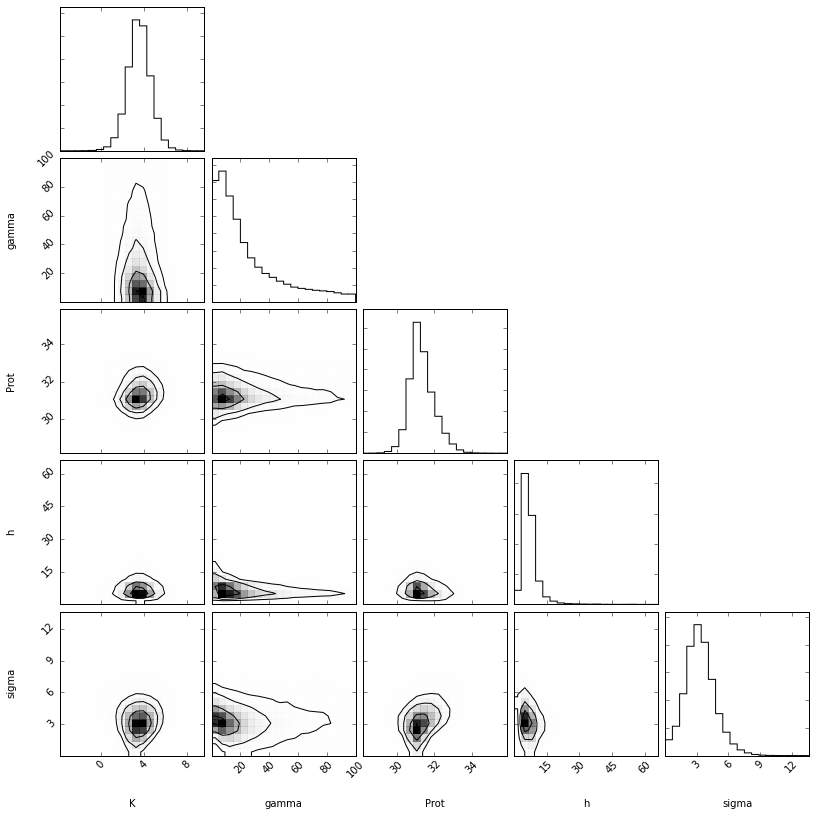

In [255]:
import triangle
fig = triangle.corner(samples, labels=["K", "gamma", "Prot", "h", "sigma"]) #truths=[m_true, b_true, np.log(f_true)   , 
fig.savefig("triangle.png")

In [256]:
(K_mcmc, gamma_mcmc, prot_mcmc, h_mcmc, sigma_mcmc) = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                                  zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))

In [257]:
print('K value {0:3.2f} +{1:3.2f} - {1:3.2f}' .format(K_mcmc[0],K_mcmc[1], K_mcmc[2] ))

K value 3.57 +1.03 - 1.03


<Container object of 3 artists>

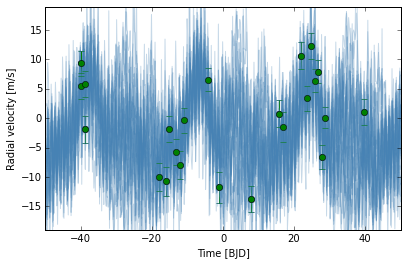

In [258]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(shortbjd, rvs)
ax.errorbar(shortbjd, rvs, yerr=error, fmt='o')
plt.xlim([-50, 50]) 
plt.ylim([-19, 19]) 

ax.set_xlabel('Time [BJD]')
ax.set_ylabel('Radial velocity [m/s]')

theoRV = -K_ml*np.sin(2.0*np.pi*phases) 

newbjd = np.linspace(-50, 50, 500)
newx = (newbjd/period) + phi0
newphases, orbit = np.modf(newx)



# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    # Set up the GP for this sample.
    K, gamma, prot, h, sigma = s
    gp = george.GP(kernels.WhiteKernel(sigma**2)+kernels.ExpSine2Kernel(gamma, prot)*h**2)
    gp.compute(shortbjd, error)
        
    # Compute the prediction conditioned on the observations and plot it.
    m = gp.sample_conditional(rvs - simplemodel(s, phases), newbjd ) + simplemodel(s, newbjd)
    ax.plot(newbjd, m, color="#4682b4", alpha=0.3)
    
    
ax.errorbar(shortbjd, rvs, yerr=error, fmt='o')